# Deep Q Network with Pong

DQN was created by DeepMind researchers, achieving superhuman performance on many Atari games (https://deepmind.com/research/dqn/). What made the accomplishments of DQN even more impressive is that the DQN had nearly the same architecture and hyperparameter settings for each game (ie no game specific knowledge or set up) and the only inputs to the DQN were the screen pixels. The main parts of the DQN are Q learning, the neural net, experience replay, target network updating, and data/environment pre-processing.


In [23]:
!pip install swig
!pip install gymnasium[box2d]

You should consider upgrading via the 'C:\Users\student\RL-Intersection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\student\RL-Intersection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\student\RL-Intersection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\student\RL-Intersection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [24]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np

In [25]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Experience Replay Buffer

Q learning is an off-policy method. In off-policy methods we often save samples and then train on them. DQN has a memory buffer that stores state, action, reward, done condition, and next state samples. In the training loop, DQN will sample from this memory buffer and train on the saved samples. The replay buffer is essentially a queue that we randomly sample from. When the queue gets full we replace the first element of the queue.

In [26]:
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u).reshape(-1,1), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

### Environment Wrappers

Wrappers modify gym environments. Wrappers can change the observation, reward, done, and info returns. Wrappers can also change the gym functions like step() and reset(). We include and use some common wrappers used in Atari games in the cells below. To use a wrapper, feed the gym env into the wrapper function like in the next cell. Sometimes problems require their own customized wrappers.

### Pong

In this notebook we'll train an agent to play the classic Atari game Pong. In Pong the agent controls a paddle and tries to hit a ball past the opponents paddle to score a point. The agent gets a positive reward when scoring a point and a negative reward when the opponent scores a point. The episode ends when a set number of points are reached.

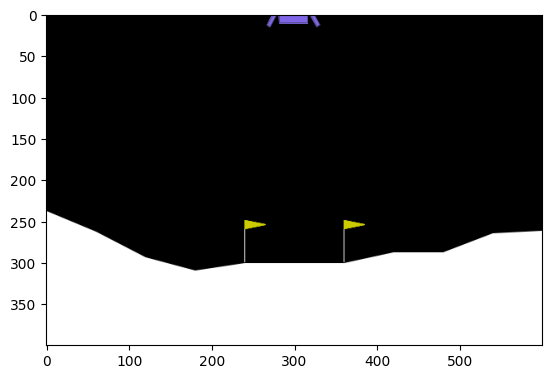

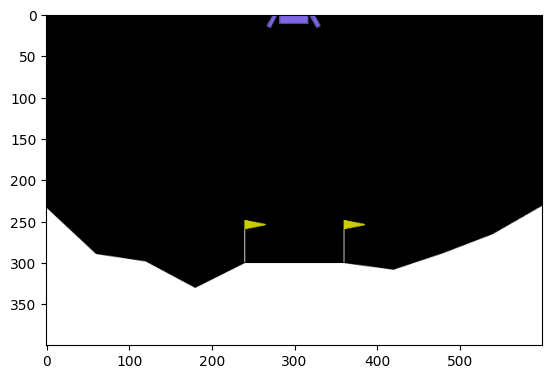

In [27]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset()

prev_screen = env.render()
plt.imshow(prev_screen)

for i in range(200):
    env.render()
    action = env.action_space.sample()
    obs, reward, termination, truncation, info = env.step(action)
    if termination or truncation:
        env.reset()

env.close()

### Deep Q Network

The Deep Q Network is from the original DQN paper and is sometimes referred to as the Nature CNN (since the article was published in Nature). Compared to state of the art CNNs in image recognition, the Nature CNN is quite simple. There are only three convolutional layers, followed by a fully connected (dense) layer and a linear layer. All but the linear layer have ReLU activations.

In [28]:
# create Deep Q Network Class by inheriting from torch.nn.Module
# based on Nature CNN from OpenAI baselines: https://github.com/openai/baselines/blob/1b092434fc51efcb25d6650e287f07634ada1e08/baselines/common/models.py
           
class DeepQNetwork(nn.Module):
    def __init__(self, observation_size, action_size, hidden_size):
        super(DeepQNetwork, self).__init__()
        self.fc_layer = nn.Linear(observation_size, hidden_size)
        # V(s) value of the state
        self.dueling_value = nn.Linear(hidden_size, 1)
        # Q(s,a) Q values of the state-action combination
        self.dueling_action = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = F.relu(self.fc_layer(x))
        # get advantage by subtracting dueling action mean from dueling action
            # then add estimated state value
        action_advantage = self.dueling_action(x) - self.dueling_action(x).mean(dim=1, keepdim=True)
        state_value = self.dueling_value(x)
        return state_value + action_advantage

    def get_state_value(self, x):
        x = F.relu(self.fc_layer(x))
        return self.dueling_value(x)

class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim=-1) + 1e-8 #-1 to take softmax of last dimension

### DQNAgent Class

We create a DQNAgent class. The agent has a train network for learning a policy and a target network for performing target network updates. The agent has a select_action() function for sampling an action based on the epsilon-greedy method. The agent has a train() function, in which the agent samples from the replay buffer and updates the neural network parameters to improve its policy. The agent also has a update_target_network() function for updating the target network parameters with the training network parameters.

In [29]:
class DQNActorCriticHybridAgent():
    def __init__(self, observation_size, action_size, hidden_size, learning_rate, actor_lr, entropy_coeff):
        self.action_size = action_size
        self.observation_size = observation_size
        self.train_net = DeepQNetwork(observation_size, action_size, hidden_size).to(device)
        self.target_net = DeepQNetwork(observation_size, action_size, hidden_size).to(device)
        self.target_net.load_state_dict(self.train_net.state_dict())
        self.optimizer = optim.Adam(self.train_net.parameters(), lr=learning_rate)

        self.actor_net = ActorNet(observation_size, action_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=actor_lr)
        self.discount = discount
        self.entropy_coeff = entropy_coeff


    # def select_action(self, s, eps):
    #     # select action according to epsilon-greedy method
    #     if np.random.rand() <= eps:
    #         a = env.action_space.sample()
    #     else:
    #         # greedy action is the largest Q value from the train network based on the input
    #         with torch.no_grad():
    #             input_state = torch.FloatTensor(np.array(s)).unsqueeze(0).to(device)
    #             a = self.train_net(input_state).max(1)[1]#.view(1, 1)#.detach().cpu().numpy()[0]
    #             a = int(a)
    #     return a
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action


    def train(self, replay_buffer, batch_size, discount):
        # train the training network
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)
        # turn batches into tensors and attack to GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.LongTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        done_batch = torch.FloatTensor(1. - d).to(device)

        # get train net Q values
        train_q = self.train_net(state_batch).gather(1, action_batch)

        # get target net Q values
        with torch.no_grad():
            # Vanilla DQN: get target values from target net
#             target_net_q = reward_batch + done_batch * discount * \
#                      torch.max( self.target_net(next_state_batch).detach(), dim=1)[0].view(batch_size, -1)

            # Double DQN: get argmax values from train network, use argmax in target network
            train_argmax = self.train_net(next_state_batch).max(1)[1].view(batch_size, 1)
            target_net_q = reward_batch + done_batch * discount * \
                    self.target_net(next_state_batch).gather(1, train_argmax)

        # get loss between train q values and target q values
            # DQN implementations typically use MSE loss or Huber loss (smooth_l1_loss is similar to Huber)
        #loss_fn = nn.MSELoss()
        #loss = loss_fn(train_q, target_net_q)
        loss = F.smooth_l1_loss(train_q, target_net_q)

        # optimize the parameters with the loss
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.train_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        # we return the loss so we can monitor loss and debug the network if necessary
        return loss.detach().cpu().numpy()


    def update_target_network(self, num_iter, update_every):
        # update target network every so often
        # hard target network update: updates target network fully with train network params
        if num_iter % update_every == 0:
            #print("Updating target network parameters")
            self.target_net.load_state_dict(self.train_net.state_dict())


    def update_target_network_soft(self, num_iter, update_every, update_tau=0.001):
        # soft target network update: update target network with mixture of train and target
        if num_iter % update_every == 0:
            for target_var, var in zip(self.target_net.parameters(), self.train_net.parameters()):
                target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)


    def train_actor(self, state_list, action_list, reward_list, next_state_list, done_list):

        # create tensors
        state_t = torch.FloatTensor(state_list).to(device)
        next_state_t = torch.FloatTensor(next_state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        reward_t = torch.FloatTensor(reward_list).to(device).view(-1,1)
        done_t = torch.FloatTensor(done_list).to(device).view(-1,1) #flipping 0 and 1 in RL training loop

        # get critic estimate
        critic_t = self.target_net.get_state_value(state_t).view(-1,1)
        with torch.no_grad():
            critic_td_t = reward_t + done_t * self.discount * self.target_net.get_state_value(next_state_t).view(-1,1)
            advantage_t = critic_td_t - critic_t

        # get action probabilities
        action_probs = self.actor_net(state_t)
        selected_action_prob = action_probs.gather(1, action_t)
        # calculate entropy loss
        entropy_loss = -torch.sum(action_probs*torch.log(action_probs), dim=1)
        # calculate actor loss
        actor_loss = torch.mean(-torch.log(selected_action_prob) * advantage_t + self.entropy_coeff * entropy_loss)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        critic_loss = F.smooth_l1_loss(critic_t, critic_td_t)
        self.optimizer.zero_grad()
        critic_loss.backward()
        self.optimizer.step()

        return actor_loss.detach().cpu().numpy(), critic_loss.detach().cpu().numpy()

### Target Network Updating

DQN has two networks: a train network and a target network. The target network provides the next-state Q values for the Q learning update. We use the next-state Q values to update the train network. Periodically we then update target network variables with the train network variables. Using a target network increases stability and convergence of the DQN.

### Hyperparameters

Hyperparameters are a variety of arguments that are usually tuned to help produce the best performing agents. Hyperparameter choice can be tricky as poor hyperparameter choice can prevent an agent from learning anything. The best choice depends on the algorithm and problem. Two basic methods that are used are random search, where you randomly pick hyperparameter values from a predefined range of values, and grid search where you systematically try all values and combinations based on a predefined grid of values.

In [30]:
# Initialize env and set up hyperparameters
env = gym.make('LunarLander-v2', render_mode='rgb_array')
action_size = env.action_space.n
observation_size = env.observation_space.shape[0]

# set seed
seed = 31
#env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
timesteps = 200000 # run env for this many time steps
hidden_size = 256   # side of hidden layer of FFNN that connects CNN to outputs
learning_rate = 0.001 # learning rate of optimizer
batch_size = 64    # size of batch trained on
start_training_after = 1001 # start training NN after this many timesteps
discount = 0.99 # discount future states by

actor_lr = 0.00005 # learning rate for actor
reward_scale = 1 #scale reward by this amount
entropy_coeff = 0.000001

update_target_every = 1 # update target network every this steps
tau = 0.001

# create replay buffer
replay_size = 100000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)

# create DQN Agent
agent = DQNActorCriticHybridAgent(observation_size, action_size, hidden_size, learning_rate, actor_lr, entropy_coeff)

### The RL Training Loop

In the loop, we iterate through our episodes and then the timesteps within the episodes. We stop training the agent based on some stopping condition like a max episode value, a max timestep value, or if the agent's performance reaches a certain level.

In each episode and at each timestep the agent selects an action, calls env.step(), and stores the sample in the replay buffer. The agent will also train the training neural network and periodically update the target network. When an episode is done the env is reset.

In [20]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
episode = 1
episode_length = 0
stats_loss = 0.
stats_actor_loss = []
stats_critic_loss = []

state, _ = env.reset(seed=seed)
state_list, action_list, reward_list, next_state_list, done_list = [], [], [], [], []

for ts in range(timesteps):
    #env.render()
    # select an action from the agent's policy
    action = agent.select_action(state)

    # enter action into the env
    next_state, reward, termination, truncation, info = env.step(action)
    total_reward += reward
    episode_length += 1
    # end episode early
    if total_reward < -250:
        truncation = 1

    # store agent's trajectory
    state_list.append(state)
    action_list.append(action)
    reward_list.append(reward * reward_scale)
    next_state_list.append(next_state)
    done_list.append(1. - float(termination))

    # train the actor
    actor_loss, critic_loss = agent.train_actor(state_list, action_list, reward_list, next_state_list, done_list)
    stats_actor_loss.append(actor_loss)
    stats_critic_loss.append(critic_loss)

    # add experience to replay buffer
    replay_buffer.add((state, next_state, action, reward, float(termination)))

    if ts > start_training_after:
        # train the agent
        stats_loss += agent.train(replay_buffer, batch_size, discount)
        # update the target network every (if conditions are met in update_target_network)
        #dqn_agent.update_target_network(ts, update_target_every) # hard target update
        agent.update_target_network_soft(ts, update_target_every, tau) # soft target update

    if termination or truncation:
        state, _ = env.reset()
        state_list, action_list, reward_list, next_state_list, done_list = [], [], [], [], []
        stats_rewards_list.append((episode, total_reward, episode_length))
        episode += 1
        total_reward = 0
        episode_length = 0

        if ts > start_training_after and episode % stats_every == 0:
            print('Episode: {}'.format(episode),
                'Timestep: {}'.format(ts),
                'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                'Loss: {:.4f}'.format(stats_loss),
                'Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)),
                'Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
            stats_actor_loss = []
            stats_critic_loss = []
            stats_loss = 0.
        
        # stopping condition for training if agent reaches the amount of reward
        if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 200:
            print("Stopping at episode {} with average rewards of {} in last {} episodes".
                format(episode, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
            break

    else:
        state = next_state
    

Episode: 80 Timestep: 6375 Total reward: -123.4 Episode length: 75.2 Loss: 669.8472 Actor Loss: -0.1470 Critic Loss: 0.1070
Episode: 90 Timestep: 7055 Total reward: -118.0 Episode length: 68.0 Loss: 644.9303 Actor Loss: -0.1785 Critic Loss: 0.1679
Episode: 100 Timestep: 7736 Total reward: -118.0 Episode length: 68.1 Loss: 657.5872 Actor Loss: -0.0571 Critic Loss: 0.1671
Episode: 110 Timestep: 8436 Total reward: -119.3 Episode length: 70.0 Loss: 727.0680 Actor Loss: -0.0951 Critic Loss: 0.1922
Episode: 120 Timestep: 9130 Total reward: -109.7 Episode length: 69.4 Loss: 767.8638 Actor Loss: -0.2396 Critic Loss: 0.2573
Episode: 130 Timestep: 9824 Total reward: -113.7 Episode length: 69.4 Loss: 741.6376 Actor Loss: -0.1625 Critic Loss: 0.2339
Episode: 140 Timestep: 10565 Total reward: -122.7 Episode length: 74.1 Loss: 799.3239 Actor Loss: -0.2213 Critic Loss: 0.2869
Episode: 150 Timestep: 11270 Total reward: -111.3 Episode length: 70.5 Loss: 731.9768 Actor Loss: -0.2103 Critic Loss: 0.3091


Text(0, 0.5, 'Episode Reward')

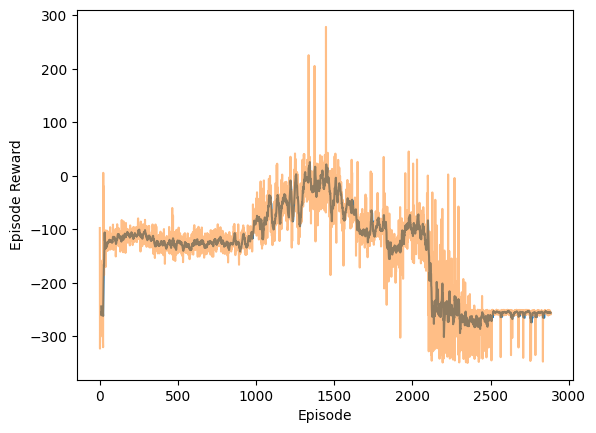

Text(0, 0.5, 'Episode Reward')

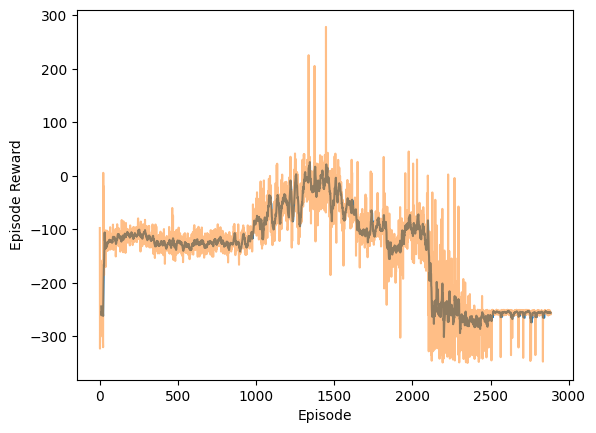

In [21]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

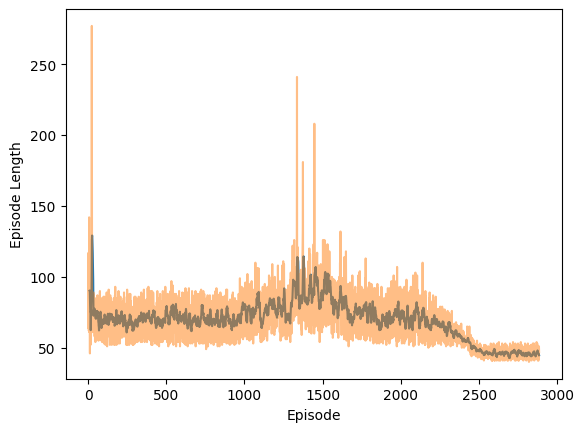

Text(0, 0.5, 'Episode Length')

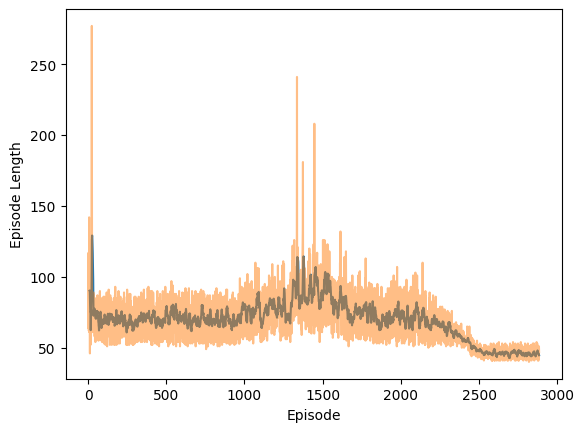

In [22]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')